# Predicting ROI using simple regression model with monte carlo method

This final project was created for a Numerical Methods course at AGH University of Science and Technology. It's goal is to predict return of investement (ROI) on a property by calculating the rent price based on regression model in pyTorch, and then simulating different outcomes with the Monte Carlo method to understand potential risks and rewards

### Import required libraries

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

### Prepare data

Number of missing values
squareMeters: 0
rooms: 0
centreDistance: 0
price: 0
collegeDistance: 5
hasParkingSpace: 0
hasBalcony: 0
hasElevator: 73
hasStorageRoom: 0


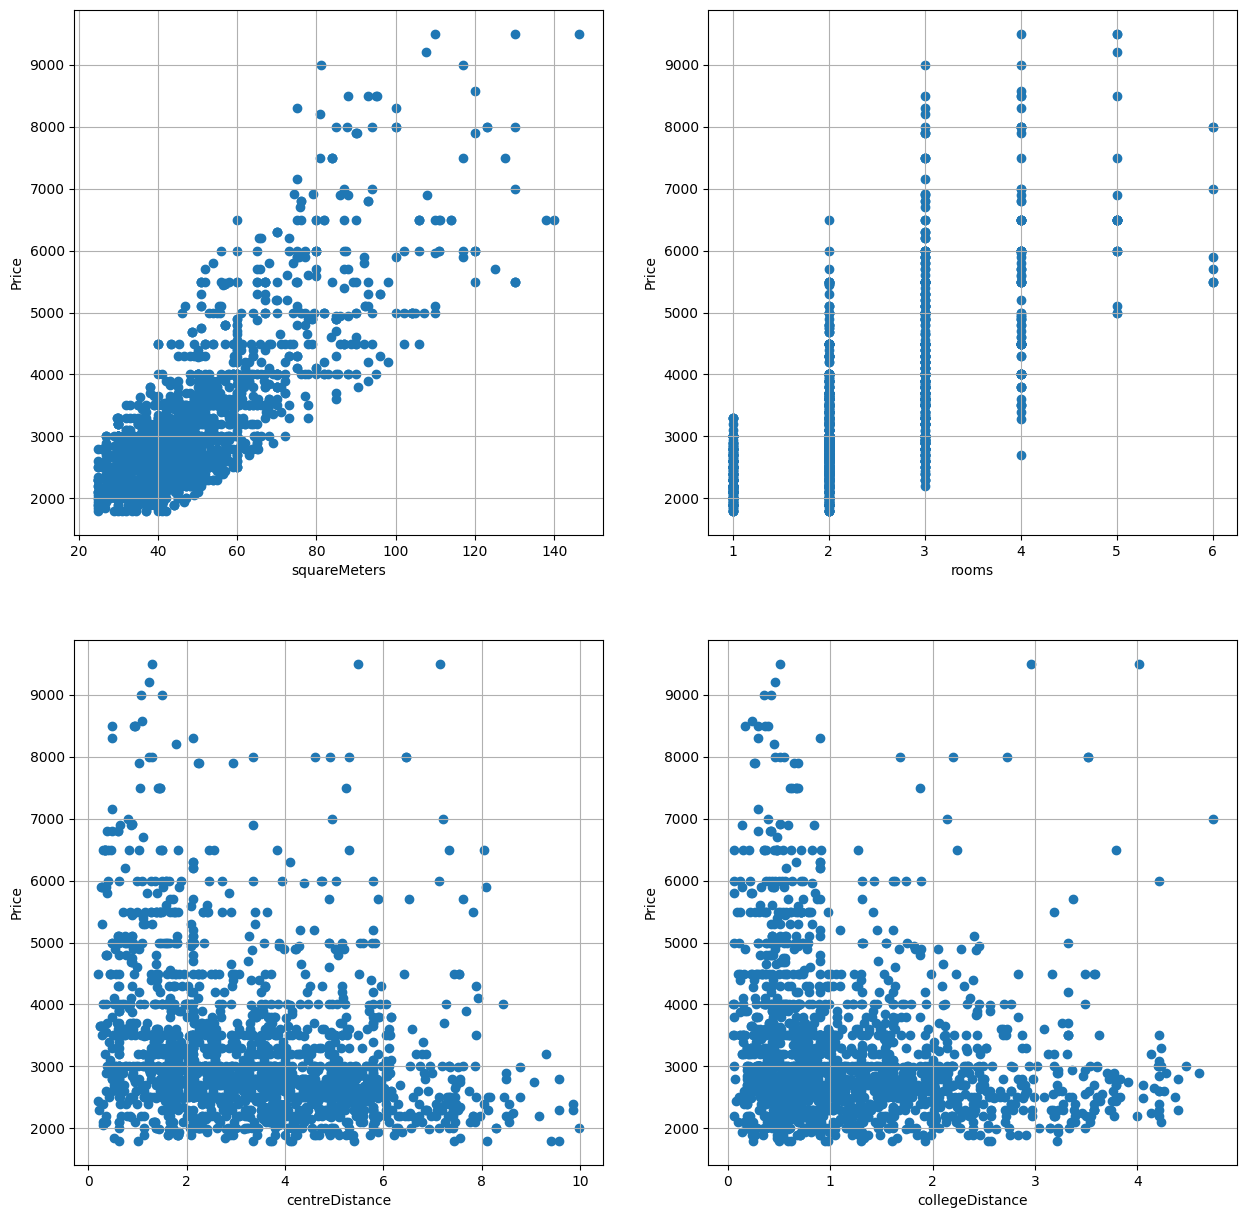

In [212]:
df = pd.read_csv('rental_data.csv')
numbers = ['squareMeters', 'rooms', 'centreDistance', 'price', 'collegeDistance']
amenities = ['hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasStorageRoom']

for column in  amenities:
    # In dataset true/false was marked as 'yes'/'no'
    df[column] = df[column].map({'yes': 1, 'no': 0})

print("Number of missing values")
for column in numbers + amenities:
    print(f'{column}: {df[column].isna().sum()}')
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

numbers =  ['squareMeters',	'rooms', 'centreDistance', 'collegeDistance']
for index, ax in enumerate(axes.flat):
    ax.scatter(df[numbers[index]], df['price'])
    ax.set_xlabel(numbers[index])
    ax.set_ylabel('Price')
    ax.grid(True)

**As we can see, property prices tend to linearly increase with both the size in square meters and the number of rooms. When it comes to the distance from the city center and the college, the further the property is, the lower the prices generally are. So, when buying a property more than 6 kilometers from the center, we can expect no more than 4k in rental income.**

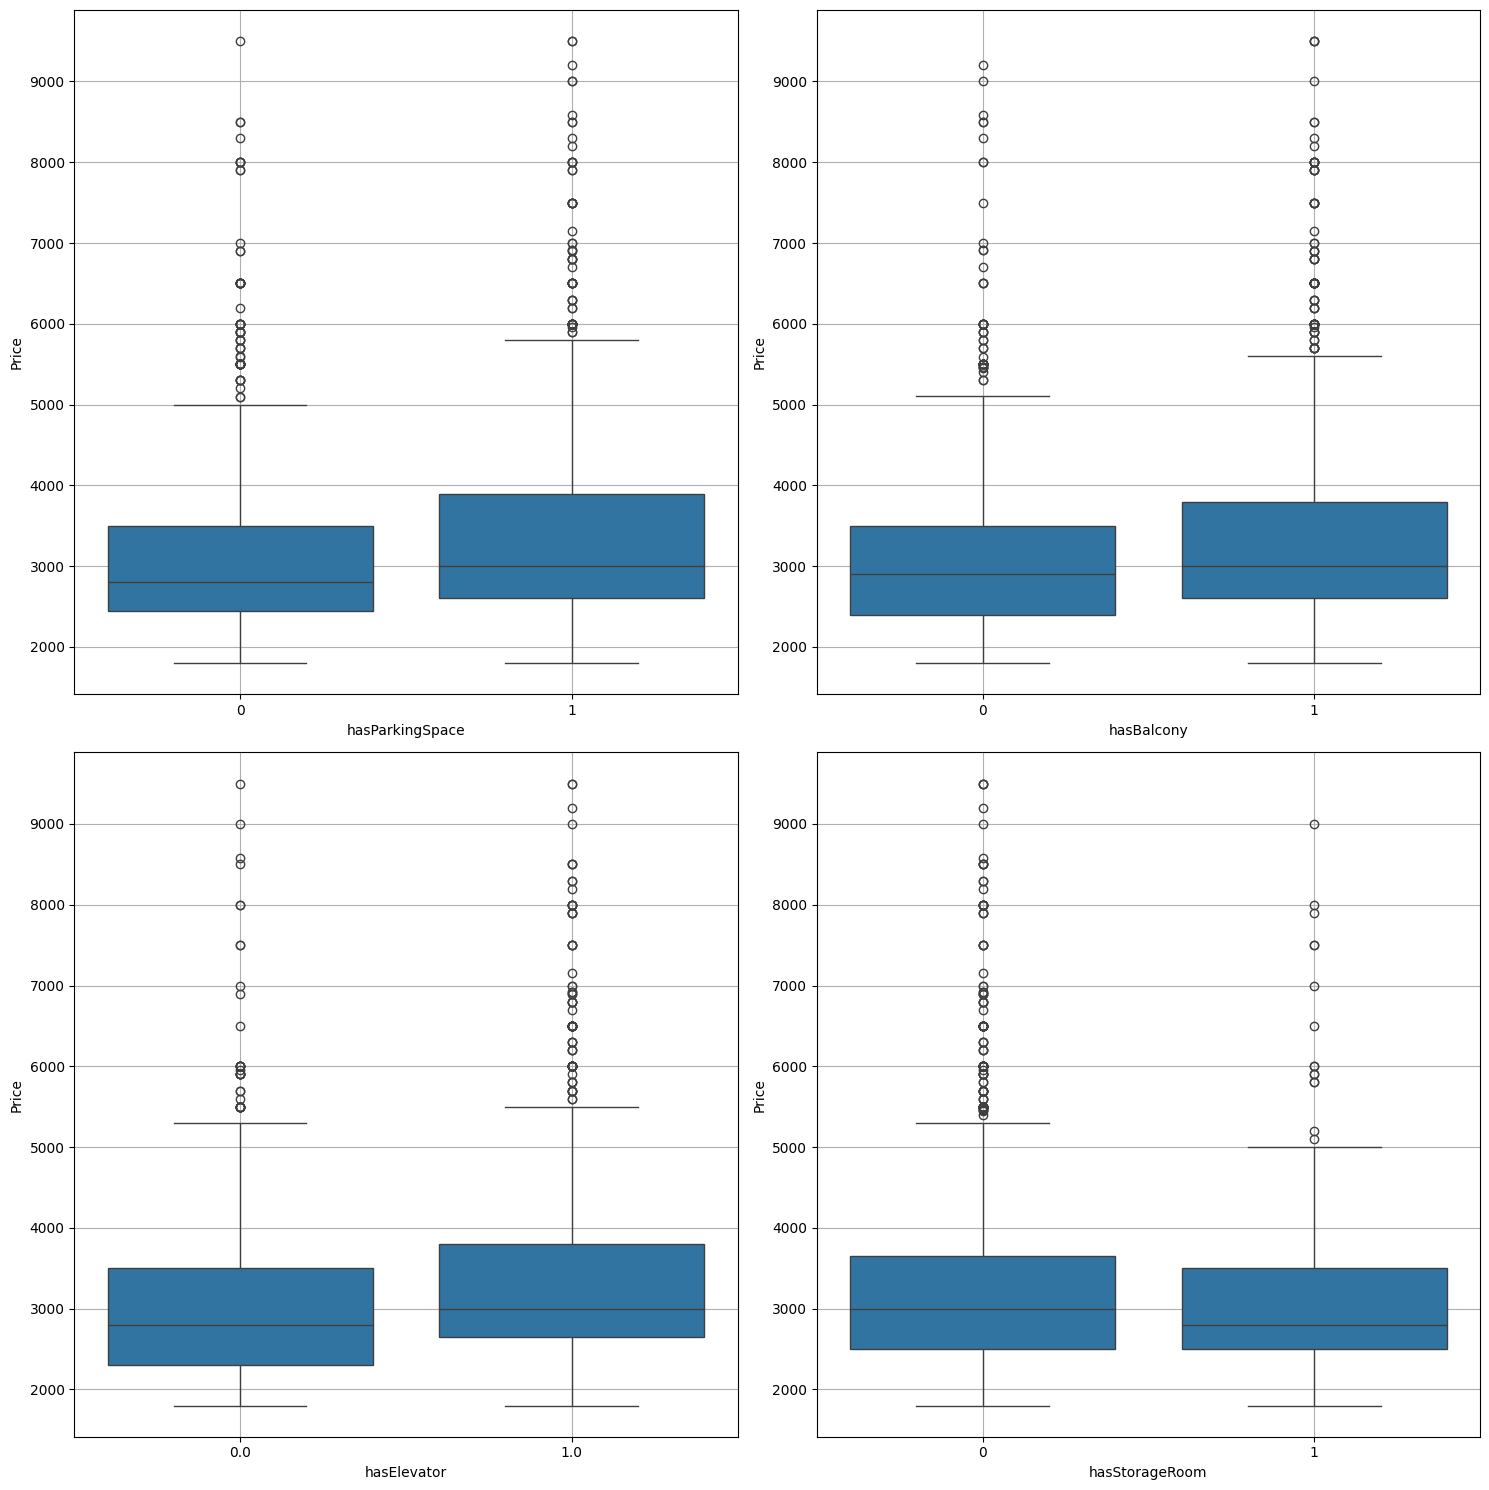

In [213]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for index, ax in enumerate(axes.flat):
    sns.boxplot(x=df[amenities[index]], y=df['price'], ax=ax)
    ax.set_xlabel(amenities[index])
    ax.set_ylabel('Price')
    ax.grid(True)

plt.tight_layout()
plt.show()

*A storage room may not be considered a critical feature when evaluating a property by a potential buyer. Condos with an elevator, balcony, and a parking space are generally more profitable to rent.*

Here is a list of features that I will use for training. I intentionally removed collegeDistance because it is mostly similar to centreDistance, hasElevator due to around 100 missing values, and storageRoom because it doesn't appear to influence the property price.

In [214]:
features = [
     'squareMeters',
     'rooms',
     'centreDistance',
     'hasParkingSpace',
     'hasBalcony',
     'price']

## Normalising data

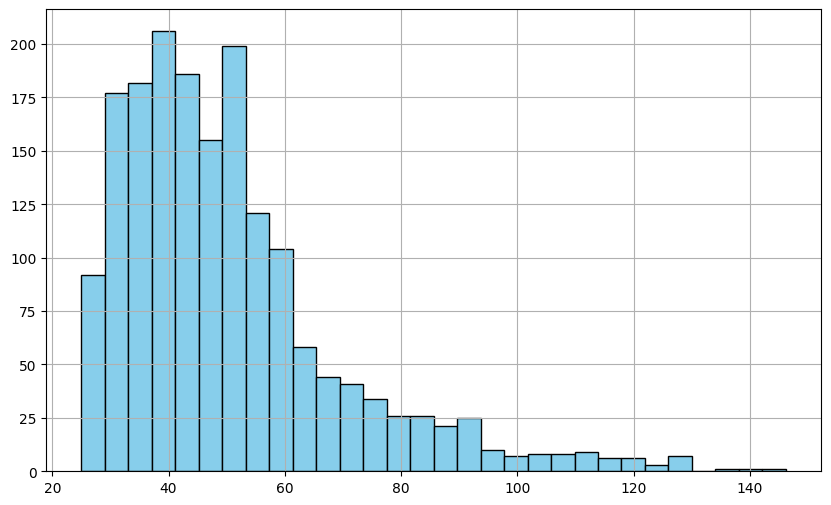

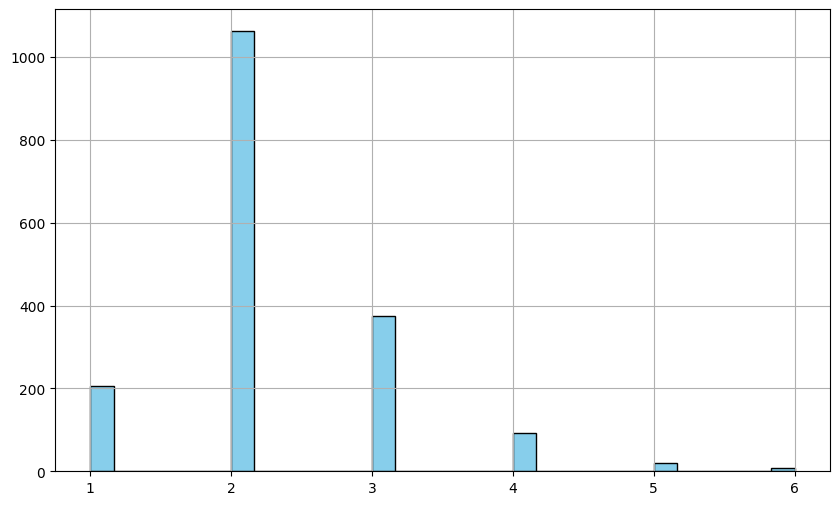

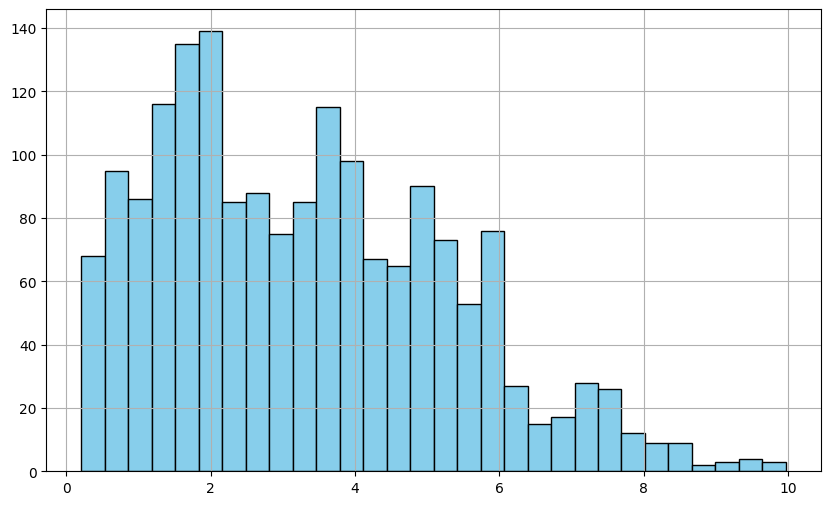

In [215]:
df = df[features]

plt.figure(figsize=(10, 6))
plt.hist(df['squareMeters'], bins=30, color='skyblue', edgecolor='black')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['rooms'], bins=30, color='skyblue', edgecolor='black')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['centreDistance'], bins=30, color='skyblue', edgecolor='black')
plt.grid(True)
plt.show()

As we can see all features are following distribution somewhat like a normal distribution, so the best normalising method will be standarization ( z-score scaling ), hasBalcony and hasParking are 0 or 1 so they are already normalised

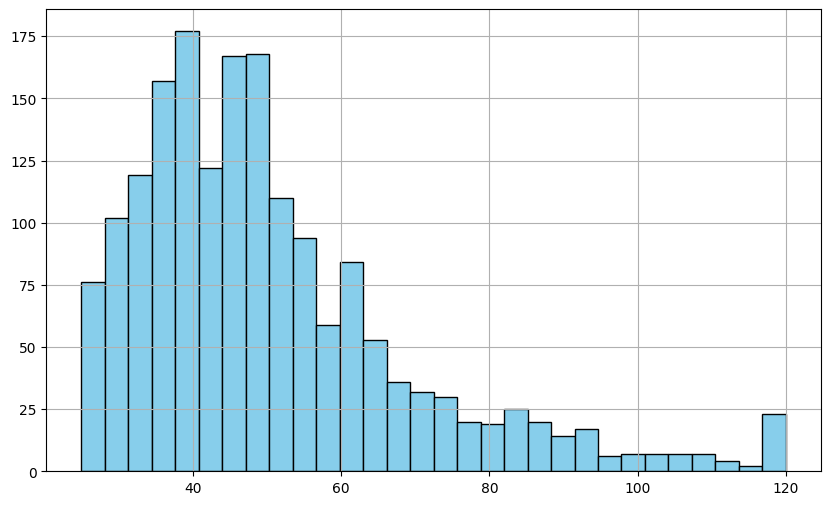

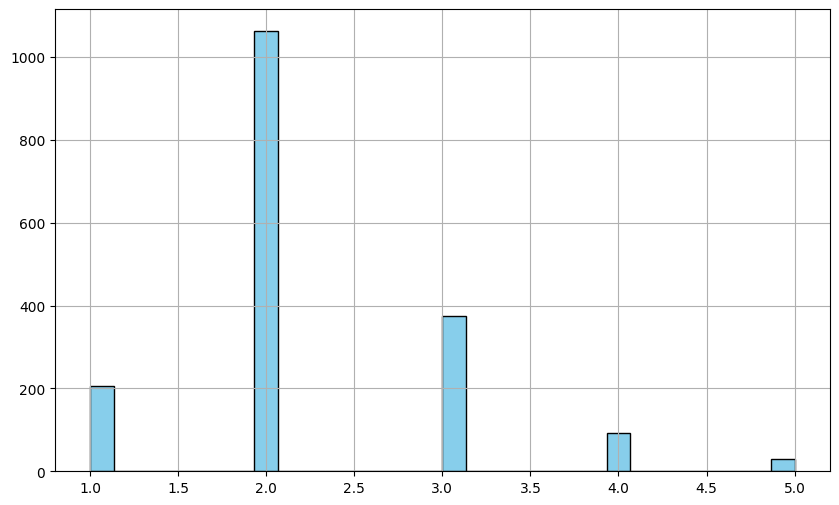

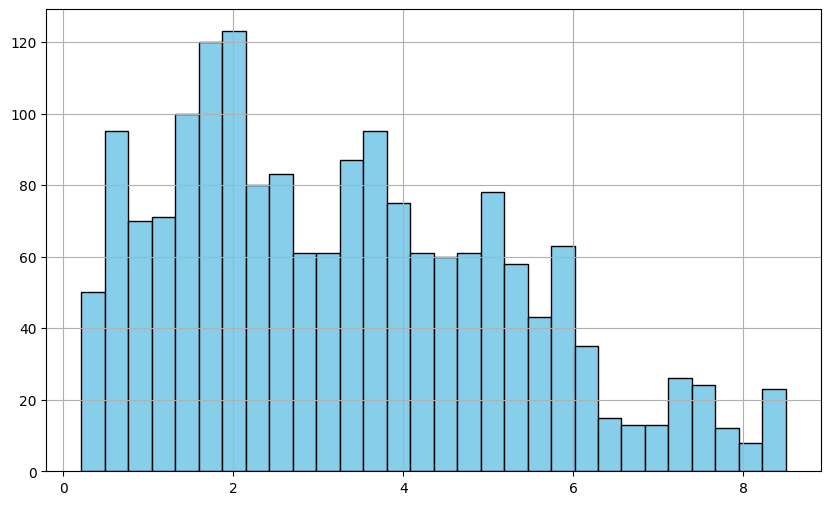

In [216]:
to_normalise = ['squareMeters',	'rooms', 'centreDistance']
for column in to_normalise:
    cap_value = df[column].quantile(0.99)
    df[column] = df[column].clip(upper=cap_value)

plt.figure(figsize=(10, 6))
plt.hist(df['squareMeters'], bins=30, color='skyblue', edgecolor='black')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['rooms'], bins=30, color='skyblue', edgecolor='black')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['centreDistance'], bins=30, color='skyblue', edgecolor='black')
plt.grid(True)
plt.show()

*For outliers i incorporated clipping so extreme values will not affect training as much*

In [217]:
to_normalise = ['squareMeters',	'rooms', 'centreDistance']
for column in to_normalise:
    df[column] = (df[column] - df[column].mean()) / df[column].std()
df


,squareMeters,rooms,centreDistance,hasParkingSpace,hasBalcony,price
0,-0.820563,-0.317680,-0.408770,1,1,2900
1,-0.714077,-0.317680,-0.008488,1,0,2500
2,0.191052,-0.317680,1.151824,0,1,2300
3,-1.140021,-1.582664,-0.601311,1,1,2650
4,-0.607591,-0.317680,0.057381,1,0,1900
...,...,...,...,...,...,...
1759,-1.086778,-0.317680,0.148585,1,1,3000
1760,0.137809,-0.317680,-1.224535,1,0,5000
1761,2.959684,3.477272,-1.477879,1,1,5999
1762,0.191052,-0.317680,-1.508280,1,0,3200


**Great now when all features are ready, it's time for normalising label ( rental price )**

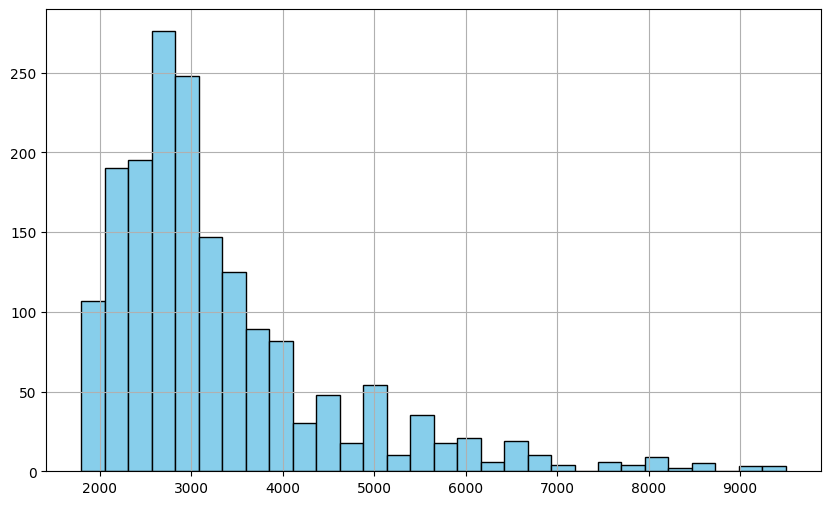

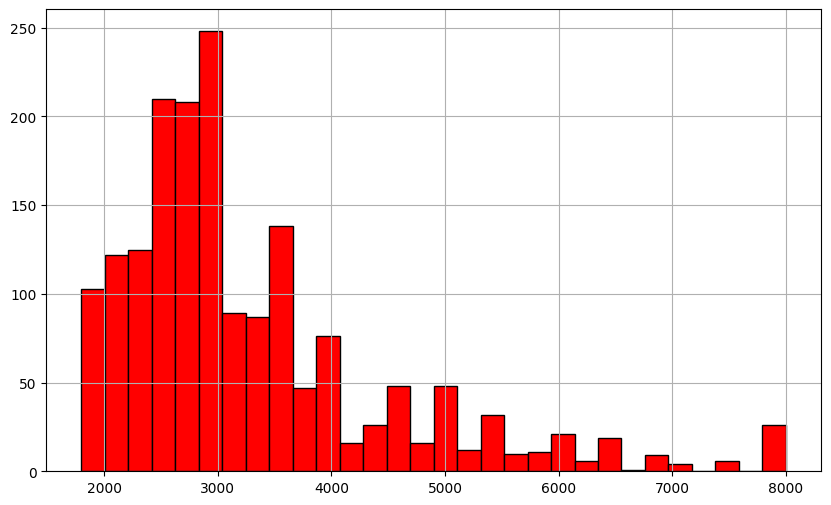

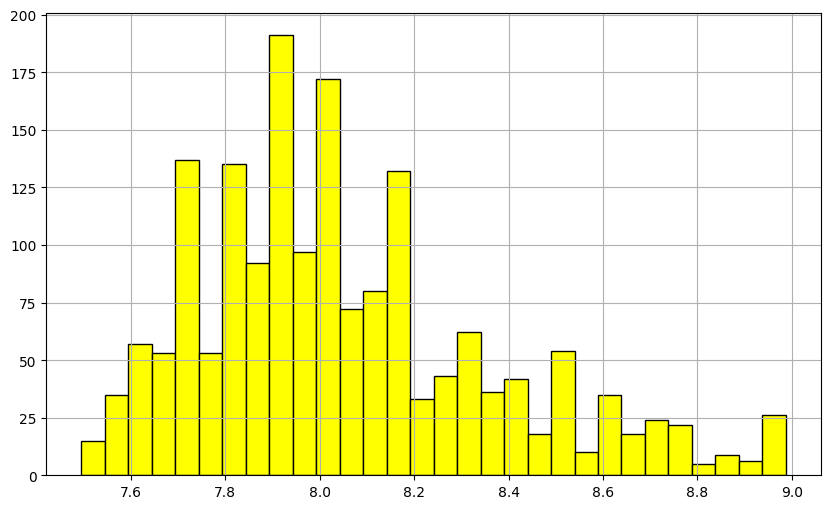

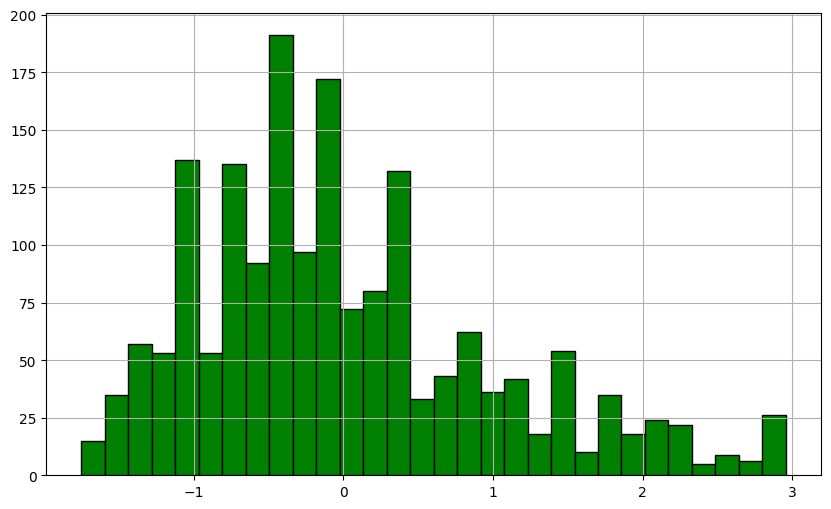

In [218]:
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=30, color='skyblue', edgecolor='black')
plt.grid(True)
plt.show()

# I will clip them to 99th percentile
cap_value = df['price'].quantile(0.99)
df['price'] = df['price'].clip(upper=cap_value)

plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=30, color='red', edgecolor='black')
plt.grid(True)
plt.show()

df['price'] = np.log(df['price'])

plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=30, color='yellow', edgecolor='black')
plt.grid(True)
plt.show()

# Price looks like normal distribution, but doesn't have mean 0 with std 1
# So our log scaled price should be standarized

df['price'] = (df['price'] - df['price'].mean()) / df['price'].std()

plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=30, color='green', edgecolor='black')
plt.grid(True)
plt.show()

After normalisation our data is ready for training and looks like this

In [219]:
df.describe()

,squareMeters,rooms,centreDistance,hasParkingSpace,hasBalcony,price
count,1.764000e+03,1.764000e+03,1.764000e+03,1764.000000,1764.000000,1.764000e+03
mean,2.295971e-16,-2.577933e-16,-7.653238e-17,0.486395,0.643991,-8.136600e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,0.499957,0.478954,1.000000e+00
min,-1.352992e+00,-1.582664e+00,-1.579216e+00,0.000000,0.000000,-1.750037e+00
25%,-7.140773e-01,-3.176803e-01,-8.153861e-01,0.000000,0.000000,-7.134080e-01
50%,-2.348910e-01,-3.176803e-01,-1.250257e-01,0.000000,1.000000,-1.391256e-01
75%,4.040240e-01,9.473039e-01,7.578754e-01,1.000000,1.000000,4.807873e-01
max,3.703408e+00,3.477272e+00,2.621215e+00,1.000000,1.000000,2.957035e+00


## Training